# **GUNITA - Programming Assignment 5**
<h2>Cybersecurity Attack Classification Using Random Forest</h2>

# Installation of Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -qU openpyxl

# Loading the Dataset

In [10]:
# Load the dataset
df = pd.read_excel('cyber_attacks.xlsx')
df.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


## Exploratory Data Analysis

In [14]:
df.shape 

(10000, 7)

In [15]:
attack_type_count = df.attack_type.value_counts() 
attack_type_count

attack_type
Normal      6000
Botnet      1000
DDoS        1000
Phishing    1000
PortScan    1000
Name: count, dtype: int64

This dataset offers a unique learning opportunity due to its near-uniform distribution of attack types, apart from the 'normal' category, which is significantly larger. Given the high frequency of 'normal' and related neutral labels, the next step is to examine and address any missing data.

Checking for missing values

In [16]:
missing_attack_type_count = df[df.isnull().any(axis=1)]['attack_type'].value_counts()

for attack_type in attack_type_count.index:
    total = attack_type_count[attack_type]
    missing = missing_attack_type_count.get(attack_type, 0) 
    percent_missing = round(missing / total * 100, 2) 
    print(f"{attack_type}: {percent_missing}% missing")

Normal: 4.9% missing
Botnet: 5.7% missing
DDoS: 4.7% missing
Phishing: 5.6% missing
PortScan: 4.6% missing


In [17]:
df_clean = df.dropna() 
cleaned_count = df_clean.attack_type.value_counts() 
cleaned_count

attack_type
Normal      5706
PortScan     954
DDoS         953
Phishing     944
Botnet       943
Name: count, dtype: int64

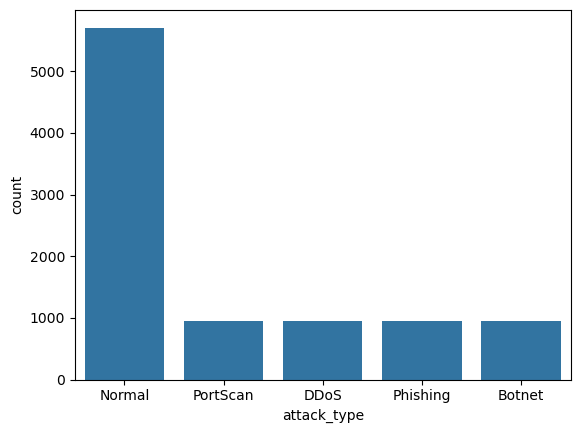

In [18]:
sns.barplot(cleaned_count);

In [19]:
df_clean.dtypes 

protocol_type        int64
duration           float64
src_bytes          float64
dst_bytes          float64
num_packets          int64
num_connections      int64
attack_type         object
dtype: object

In [20]:
one_hot_encoding = pd.get_dummies(df_clean['protocol_type'], prefix='protocol')

df_encoded = pd.concat([one_hot_encoding, df_clean.drop(columns=['protocol_type'])], axis=1)

df_encoded.rename(columns={'protocol_0':'TCP', 'protocol_1':'UDP', 'protocol_2':'ICMP'}, inplace=True)
df_encoded.head()

,TCP,UDP,ICMP,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,False,True,False,43.418651,1701.411601,201.794741,42,15,Botnet
1,False,True,False,8.587924,409.971403,710.745376,17,6,Normal
2,False,True,False,4.386891,418.478693,559.457816,17,5,Normal
4,True,False,False,1.061892,494.253699,572.459614,11,3,Normal
5,True,False,False,30.718808,1471.686910,15.383583,40,19,Botnet


In [21]:
# Separate features and labels
x = df_encoded.drop(columns=['attack_type'])
y = df_encoded['attack_type']

# Split dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69, stratify=y)

Stratify the dataset by labels to ensure that the training set accurately reflects the distribution of all attack types.

## Model Training

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
}
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_grid_search(param_grid, x_train, x_test, y_train, y_test):

    # Initialize the Random Forest Classifier
    rf = RandomForestClassifier(random_state=69)

    # Define the scoring metrics for evaluation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Train the Grid Search model
    grid_search.fit(x_train, y_train) 

    # Print the best hyperparameters and cross-validation accuracy
    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Accuracy Score:", grid_search.best_score_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)
    
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Test Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Test Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Test F1 Score:", f1_score(y_test, y_pred, average='macro'))

    return best_model

best_model = run_grid_search(param_grid, x_train, x_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best CV Accuracy Score: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0


The GridSearchCV process yielded a Random Forest Classifier with optimal hyperparameters of max_depth: None and n_estimators: 100. Remarkably, this model achieved perfect scores across all evaluation metrics (accuracy, precision, recall, and F1-score) on both the cross-validation and test sets, indicating exceptional performance. This suggests the model perfectly learned the patterns within the training data and generalized flawlessly to the test data. However, such perfect scores warrant careful consideration for potential overfitting or data leakage. 

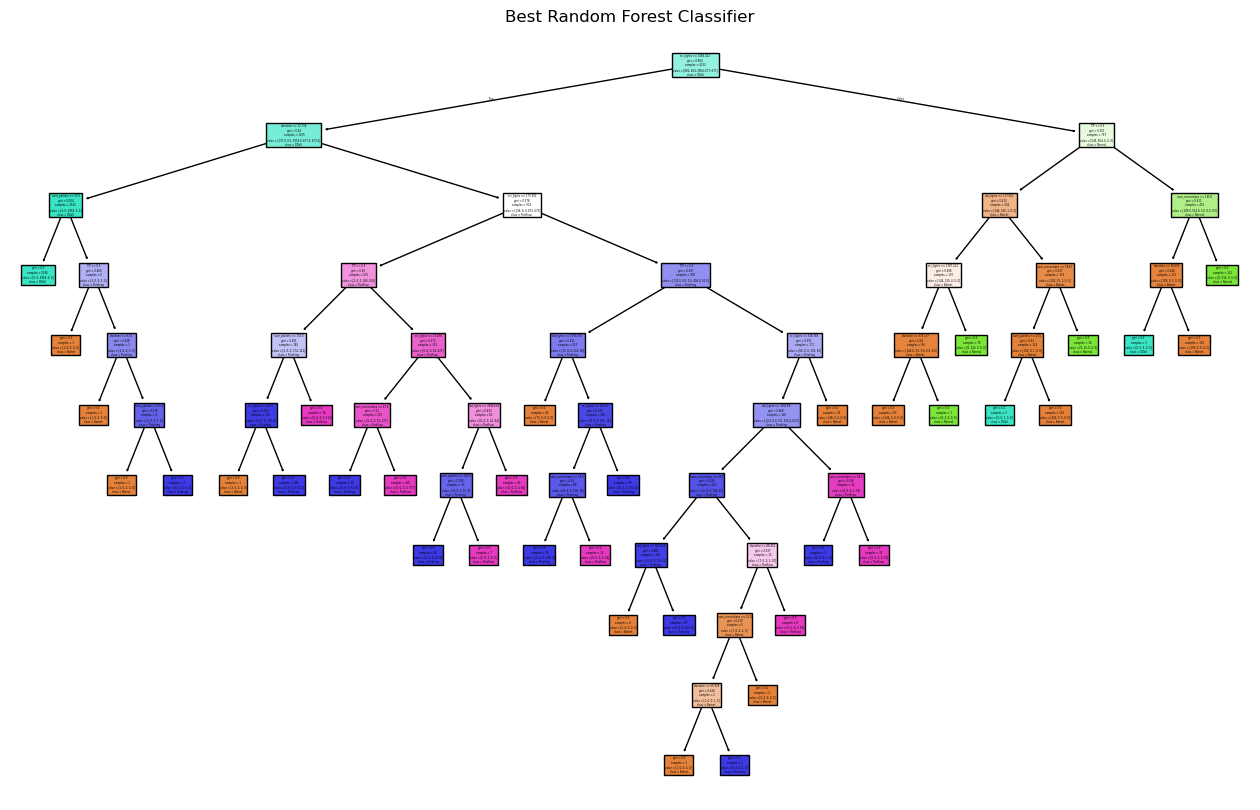

In [23]:
def visualize_tree(x, y, best_model, title):
    # Visualizing a single tree from Random Forest
    plt.figure(figsize=(16,10))
    
    # Extract feature and class names for visualization
    feature_names = x.columns.to_list()
    class_names = y.unique()
    
   # Plot the first tree from the Random Forest ensemble
    plot_tree(decision_tree=best_model.estimators_[0], # Changed 'estimator=' to 'decision_tree='
              feature_names=feature_names,
              class_names=class_names,
              filled=True)
    plt.title(title)
    plt.show()

visualize_tree(x, y, best_model, 'Best Random Forest Classifier')

Feature Importances:
num_packets: 0.3045
num_connections: 0.2684
duration: 0.1671
dst_bytes: 0.1263
src_bytes: 0.1254
TCP: 0.0054
ICMP: 0.0025
UDP: 0.0003


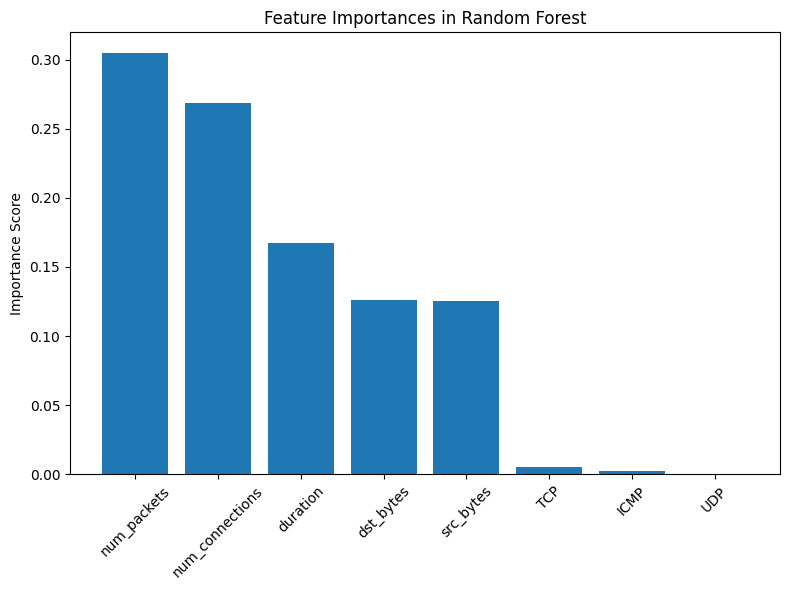

In [ ]:
def plot_feature_importances(x, y, best_model, title):
    feature_names = x.columns.to_list()
    class_names = y.unique()
    
    # Calculate and sort feature importances
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("Feature Importances:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    
    # Visualize Feature Importance
    plt.figure(figsize=(8, 6))
    plt.title("Feature Importances in Random Forest")
    plt.bar(range(x.shape[1]), importances[indices], align="center")
    plt.xticks(range(x.shape[1]), [feature_names[i] for i in indices], rotation=45)
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

plot_feature_importances(x, y, best_model, 'Feature Importances in Random Forest')

Since TCP, ICMP, and UDP have low feature importance, removing them, along with one-hot encoded features, will simplify the model, likely resulting in a shallower tree and reduced overfitting. 

In [15]:
# Remove the protocol_type
x = df_clean.drop(columns=['attack_type', 'protocol_type'])
y = df_clean['attack_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69, stratify=y)

best_model_no_protocol = run_grid_search(param_grid, x_train, x_test, y_train, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best CV Accuracy Score: 1.0
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0


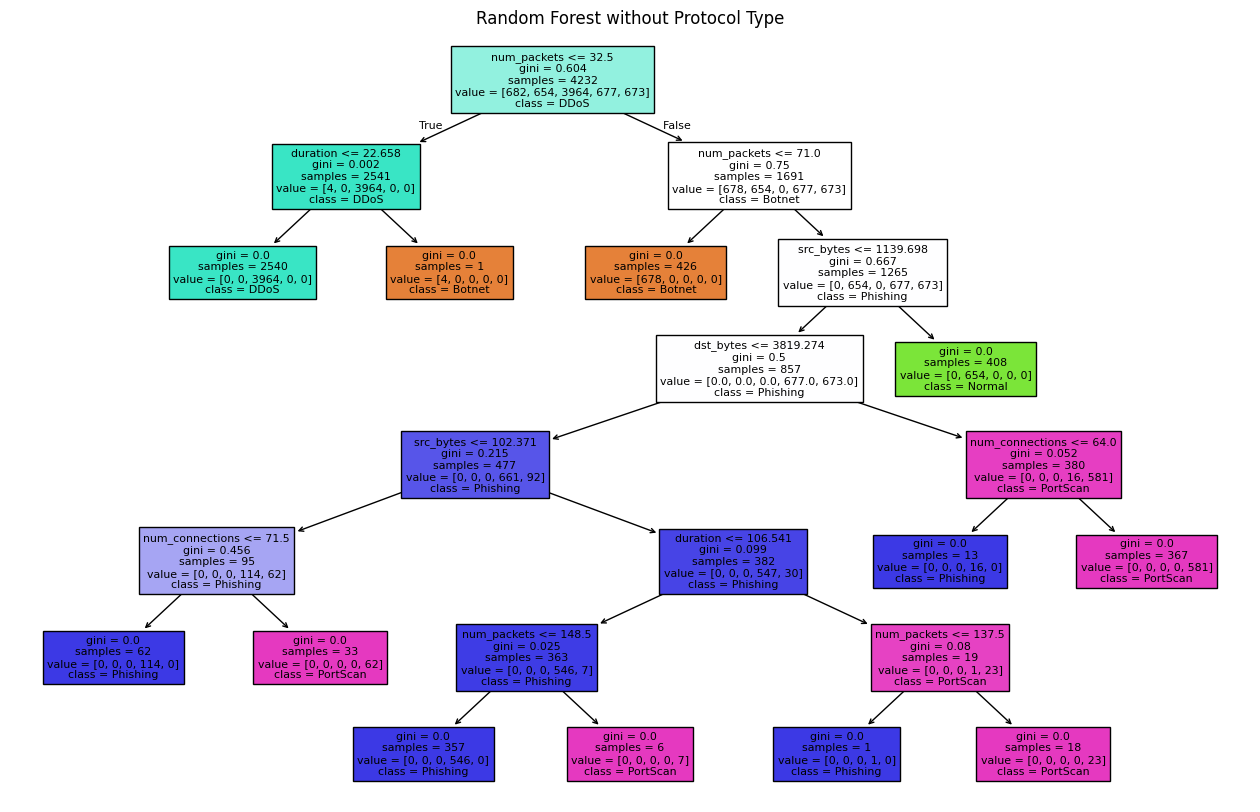

In [ ]:
visualize_tree(x, y, best_model_no_protocol, 'Random Forest without Protocol Type')

Feature Importances:
num_packets: 0.3782
num_connections: 0.2328
duration: 0.2073
dst_bytes: 0.1246
src_bytes: 0.0571


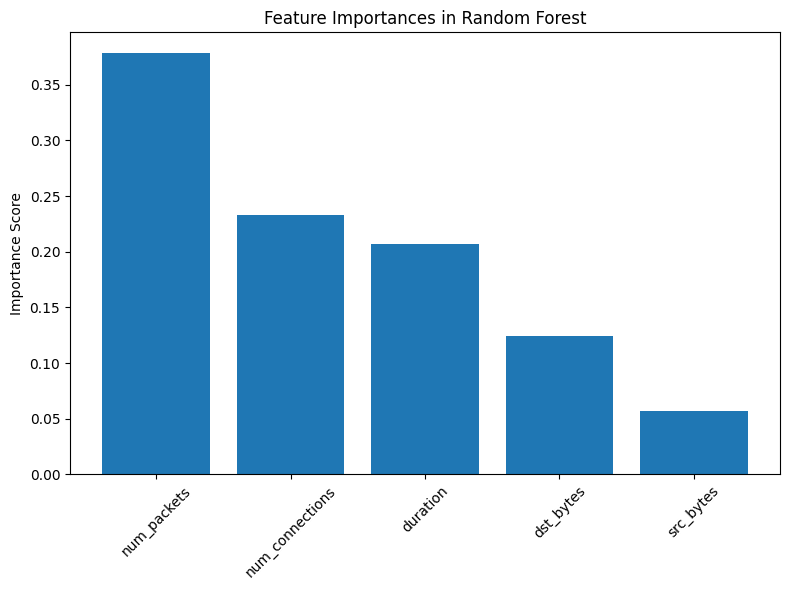

In [ ]:
# Visualize feature importances after removing protocol type features
plot_feature_importances(x, y, best_model_no_protocol, 'Feature Importances without Protocol Type')

## Guide Questions

### Guide Question 1
*Preprocessing* <br>
- How did you handle missing values in numerical features? <br> <br>
We chose to remove the missing values since only 5% of the data is missing for each attack type, which preserved the distribution for non-normal attack types. While the missing values could indicate another overlooked attack type, addressing this is beyond the scope of our work. Given our limited domain knowledge, it's reasonable to exclude them for now and analyze them separately later. <br> <br>

- Why is there a need to encode protocol_type feature, and which encoding method can 
be used? <br> <br>
The `protocol_type` is a categorical feature encoded as integers, but it should be one-hot encoded to prevent the random forest classifier from interpreting it as a numerical variable. In many cases, it's more effective to represent categorical features as embeddings to avoid the model making incorrect numerical assumptions, especially for tree-based models. <br> <br>


### Guide Question 2
*Model Training* <br>
- How did you address class imbalance in the dataset? <br> <br>
There is a class difference between regular and other attack types.  In reality, however, it is typical for neutral categories to have more data points.  To ensure that there are a sufficient number of data points for each class in both the training and testing sets, we stratified the dataset by splitting it across the labels. <br> <br>

- What hyperparameters of the Random Forest did you tune, and why? <br> <br>
We adjusted `max_depth` and `n_estimators` since they are the key sensitive hyperparameters for tree-based models. The `max_depth` defines how deep the tree can grow, while `n_estimators` specifies the number of trees created.<br> <br>

- Why is a pipeline useful for this task? <br> <br>
A pipeline could be useful for tasks like one-hot encoding, as it allows for encoding and preprocessing to be streamlined, especially when there are multiple preprocessing steps needed. However, we opted for a simpler approach, as suggested by pandas. According to the lecture, tree-based models like Random Forest perform well even without the need for scaling, so we decided to skip that step. <br> <br>


### Guide Question 3
*Evaluation* <br>
- Why is accuracy alone insufficient to evaluate this model? <br> <br>
Accuracy alone doesn't provide a complete understanding for the analyst. It is essential to consider other metrics like precision, recall, and especially the F1-score. These metrics are crucial due to the inherent imbalance in the dataset. <br> <br>

- Which attack type was hardest to classify, and why might this be? <br> <br>
Nothing went wrong. We managed the data effectively, stratified it, and evaluated it using various metrics for all class types. The model performed well across every class. It's possible that the data was synthetically generated using hard-coded constraints or distributions, and the model was able to identify and adapt to these patterns. <br> <br>

- How would you improve the model’s performance on minority classes? <br> <br>
The main solution is to gather more data for the minority classes. Without sufficient data, the model will struggle to generalize and make accurate decisions when identifying those minority classes. We can also apply the techniques used in this lab, such as stratification during data splitting. Additionally, we could consider undersampling by removing data points from the majority class to prevent the model from becoming too biased toward it. <br> <br>


### Guide Question 4
*Interpretation* <br>
- Which features were most important for classification? Does this align with real-world 
attack patterns? <br> <br>
The feature importances, ranked from most to least important, are number of packets, number of connections, duration, number of destination bytes, and number of source bytes. These features align with common cybersecurity patterns, where high packet counts indicate abnormal data flow, multiple connections suggest listening nodes, and longer durations point to sustained traffic, all of which can signal malicious activity. <br> <br>

- How would you explain the model’s decision-making process to a non-technical team? <br> <br>
The model we used in this laboratory is a random forest, an ensemble of decision trees. While this model can be sensitive to overfitting and may struggle with generalization compared to other methods, it excels in observability, which many models lack. The decision tree structure clearly outlines the decisions made by the model to identify the correct type of attack, making it easily interpretable for non-technical individuals. <br> <br>


### Guide Question 5
*Application* <br>
- What steps would you take to deploy this model in a real-time network monitoring 
system? <br> <br>
Deploying this model requires a pipeline for preprocessing, scheduled training for new data validated by the cybersecurity team, and continuous fine-tuning in a CI/CD pipeline. A tool to extract features for the pipeline and a user interface for displaying predictions should also be developed. <br> <br>

- How would you handle new attack types not present in the training data? <br>
Handling new attack types requires data. We can't assume our model will identify all attack types, as this could lead to critical flaws. By retraining the model with new data in a defined pipeline, we can adapt to new threats. However, this process must be clearly outlined to avoid misclassifications, as errors could lead to serious business or financial consequences.<br> <br>